In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : True,
    'balance_bins'  : 40,
    'balance_ratio' : 1,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_40_1_1_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 828)
(734160, 1)
validation
(101248, 828)
(101248, 1)
test
(100432, 828)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:54 - loss: 0.0436 - STD: 1.2208e-04 - MAE: 0.2002

 4/74 [>.............................] - ETA: 2s - loss: 0.0271 - STD: 2.4130e-04 - MAE: 0.1237  

 5/74 [=>............................] - ETA: 2s - loss: 0.0271 - STD: 2.2501e-04 - MAE: 0.1236

 6/74 [=>............................] - ETA: 3s - loss: 0.0263 - STD: 2.1548e-04 - MAE: 0.1207

 7/74 [=>............................] - ETA: 3s - loss: 0.0252 - STD: 2.1645e-04 - MAE: 0.1154

 8/74 [==>...........................] - ETA: 3s - loss: 0.0238 - STD: 2.2732e-04 - MAE: 0.1087

 9/74 [==>...........................] - ETA: 3s - loss: 0.0225 - STD: 2.4517e-04 - MAE: 0.1042

10/74 [===>..........................] - ETA: 3s - loss: 0.0216 - STD: 2.6682e-04 - MAE: 0.1030

11/74 [===>..........................] - ETA: 3s - loss: 0.0211 - STD: 2.8954e-04 - MAE: 0.1038

12/74 [===>..........................] - ETA: 3s - loss: 0.0208 - STD: 3.1211e-04 - MAE: 0.1050

13/74 [====>.........................] - ETA: 6s - loss: 0.0207 - STD: 3.3350e-04 - MAE: 0.1055

16/74 [=====>........................] - ETA: 5s - loss: 0.0191 - STD: 3.8615e-04 - MAE: 0.1013

18/74 [======>.......................] - ETA: 5s - loss: 0.0184 - STD: 4.1046e-04 - MAE: 0.0967

19/74 [======>.......................] - ETA: 4s - loss: 0.0181 - STD: 4.2126e-04 - MAE: 0.0949

20/74 [=======>......................] - ETA: 4s - loss: 0.0179 - STD: 4.3195e-04 - MAE: 0.0932

21/74 [=======>......................] - ETA: 4s - loss: 0.0177 - STD: 4.4325e-04 - MAE: 0.0917

22/74 [=======>......................] - ETA: 4s - loss: 0.0175 - STD: 4.5526e-04 - MAE: 0.0902

23/74 [========>.....................] - ETA: 4s - loss: 0.0172 - STD: 4.6892e-04 - MAE: 0.0889

24/74 [========>.....................] - ETA: 4s - loss: 0.0170 - STD: 4.8387e-04 - MAE: 0.0877

25/74 [=========>....................] - ETA: 4s - loss: 0.0168 - STD: 5.0057e-04 - MAE: 0.0870

26/74 [=========>....................] - ETA: 3s - loss: 0.0166 - STD: 5.1840e-04 - MAE: 0.0865

27/74 [=========>....................] - ETA: 3s - loss: 0.0165 - STD: 5.3750e-04 - MAE: 0.0864

28/74 [==========>...................] - ETA: 3s - loss: 0.0163 - STD: 5.5691e-04 - MAE: 0.0863

29/74 [==========>...................] - ETA: 3s - loss: 0.0162 - STD: 5.7677e-04 - MAE: 0.0863

30/74 [===========>..................] - ETA: 3s - loss: 0.0161 - STD: 5.9686e-04 - MAE: 0.0862

31/74 [===========>..................] - ETA: 3s - loss: 0.0159 - STD: 6.1686e-04 - MAE: 0.0860

32/74 [===========>..................] - ETA: 3s - loss: 0.0158 - STD: 6.3669e-04 - MAE: 0.0857

33/74 [============>.................] - ETA: 3s - loss: 0.0157 - STD: 6.5650e-04 - MAE: 0.0852

34/74 [============>.................] - ETA: 3s - loss: 0.0156 - STD: 6.7573e-04 - MAE: 0.0846

35/74 [=============>................] - ETA: 3s - loss: 0.0155 - STD: 6.9493e-04 - MAE: 0.0840

36/74 [=============>................] - ETA: 2s - loss: 0.0154 - STD: 7.1467e-04 - MAE: 0.0833

37/74 [==============>...............] - ETA: 2s - loss: 0.0153 - STD: 7.3502e-04 - MAE: 0.0827

38/74 [==============>...............] - ETA: 2s - loss: 0.0152 - STD: 7.5702e-04 - MAE: 0.0822

39/74 [==============>...............] - ETA: 2s - loss: 0.0152 - STD: 7.8026e-04 - MAE: 0.0817

40/74 [===============>..............] - ETA: 2s - loss: 0.0151 - STD: 8.0464e-04 - MAE: 0.0813

41/74 [===============>..............] - ETA: 2s - loss: 0.0150 - STD: 8.3151e-04 - MAE: 0.0809

42/74 [================>.............] - ETA: 2s - loss: 0.0149 - STD: 8.5997e-04 - MAE: 0.0807

43/74 [================>.............] - ETA: 2s - loss: 0.0148 - STD: 8.9069e-04 - MAE: 0.0805

44/74 [================>.............] - ETA: 2s - loss: 0.0148 - STD: 9.2229e-04 - MAE: 0.0804

45/74 [=================>............] - ETA: 2s - loss: 0.0147 - STD: 9.5598e-04 - MAE: 0.0803

46/74 [=================>............] - ETA: 2s - loss: 0.0146 - STD: 9.9157e-04 - MAE: 0.0802

47/74 [==================>...........] - ETA: 2s - loss: 0.0146 - STD: 0.0010 - MAE: 0.0800    

48/74 [==================>...........] - ETA: 1s - loss: 0.0145 - STD: 0.0011 - MAE: 0.0798

49/74 [==================>...........] - ETA: 1s - loss: 0.0145 - STD: 0.0011 - MAE: 0.0796

50/74 [===================>..........] - ETA: 1s - loss: 0.0144 - STD: 0.0011 - MAE: 0.0793

51/74 [===================>..........] - ETA: 1s - loss: 0.0143 - STD: 0.0012 - MAE: 0.0790

52/74 [====================>.........] - ETA: 1s - loss: 0.0143 - STD: 0.0012 - MAE: 0.0787

53/74 [====================>.........] - ETA: 1s - loss: 0.0142 - STD: 0.0013 - MAE: 0.0784

54/74 [====================>.........] - ETA: 1s - loss: 0.0142 - STD: 0.0013 - MAE: 0.0782

55/74 [=====================>........] - ETA: 1s - loss: 0.0141 - STD: 0.0014 - MAE: 0.0779

56/74 [=====================>........] - ETA: 1s - loss: 0.0141 - STD: 0.0015 - MAE: 0.0778

57/74 [======================>.......] - ETA: 1s - loss: 0.0141 - STD: 0.0015 - MAE: 0.0776

58/74 [======================>.......] - ETA: 1s - loss: 0.0140 - STD: 0.0016 - MAE: 0.0775

59/74 [======================>.......] - ETA: 1s - loss: 0.0140 - STD: 0.0017 - MAE: 0.0774

60/74 [=======================>......] - ETA: 1s - loss: 0.0139 - STD: 0.0017 - MAE: 0.0772

61/74 [=======================>......] - ETA: 0s - loss: 0.0139 - STD: 0.0018 - MAE: 0.0771

62/74 [========================>.....] - ETA: 0s - loss: 0.0138 - STD: 0.0019 - MAE: 0.0770

63/74 [========================>.....] - ETA: 0s - loss: 0.0138 - STD: 0.0020 - MAE: 0.0768

64/74 [========================>.....] - ETA: 0s - loss: 0.0137 - STD: 0.0021 - MAE: 0.0766

65/74 [=========================>....] - ETA: 0s - loss: 0.0137 - STD: 0.0022 - MAE: 0.0763

66/74 [=========================>....] - ETA: 0s - loss: 0.0136 - STD: 0.0023 - MAE: 0.0762

67/74 [==========================>...] - ETA: 0s - loss: 0.0136 - STD: 0.0025 - MAE: 0.0759

68/74 [==========================>...] - ETA: 0s - loss: 0.0135 - STD: 0.0026 - MAE: 0.0757

69/74 [==========================>...] - ETA: 0s - loss: 0.0135 - STD: 0.0028 - MAE: 0.0756

70/74 [===========================>..] - ETA: 0s - loss: 0.0134 - STD: 0.0029 - MAE: 0.0754

71/74 [===========================>..] - ETA: 0s - loss: 0.0134 - STD: 0.0031 - MAE: 0.0752

72/74 [============================>.] - ETA: 0s - loss: 0.0133 - STD: 0.0033 - MAE: 0.0750

73/74 [============================>.] - ETA: 0s - loss: 0.0133 - STD: 0.0035 - MAE: 0.0749

74/74 [==============================] - ETA: 0s - loss: 0.0132 - STD: 0.0038 - MAE: 0.0747

74/74 [==============================] - 8s 82ms/step - loss: 0.0132 - STD: 0.0038 - MAE: 0.0747 - val_loss: 0.0110 - val_STD: 0.0157 - val_MAE: 0.0621


Epoch 2/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0091 - STD: 0.0228 - MAE: 0.0592

 2/74 [..............................] - ETA: 4s - loss: 0.0090 - STD: 0.0239 - MAE: 0.0585

 3/74 [>.............................] - ETA: 4s - loss: 0.0089 - STD: 0.0249 - MAE: 0.0575

 4/74 [>.............................] - ETA: 4s - loss: 0.0087 - STD: 0.0260 - MAE: 0.0568

 5/74 [=>............................] - ETA: 4s - loss: 0.0088 - STD: 0.0274 - MAE: 0.0567

 6/74 [=>............................] - ETA: 4s - loss: 0.0086 - STD: 0.0289 - MAE: 0.0565

 7/74 [=>............................] - ETA: 4s - loss: 0.0085 - STD: 0.0304 - MAE: 0.0562

 8/74 [==>...........................] - ETA: 4s - loss: 0.0084 - STD: 0.0320 - MAE: 0.0559

 9/74 [==>...........................] - ETA: 4s - loss: 0.0082 - STD: 0.0336 - MAE: 0.0556

10/74 [===>..........................] - ETA: 4s - loss: 0.0081 - STD: 0.0352 - MAE: 0.0551

11/74 [===>..........................] - ETA: 4s - loss: 0.0079 - STD: 0.0367 - MAE: 0.0546

12/74 [===>..........................] - ETA: 4s - loss: 0.0078 - STD: 0.0383 - MAE: 0.0540

13/74 [====>.........................] - ETA: 4s - loss: 0.0076 - STD: 0.0399 - MAE: 0.0536

14/74 [====>.........................] - ETA: 4s - loss: 0.0075 - STD: 0.0415 - MAE: 0.0532

15/74 [=====>........................] - ETA: 3s - loss: 0.0074 - STD: 0.0433 - MAE: 0.0529

16/74 [=====>........................] - ETA: 3s - loss: 0.0072 - STD: 0.0450 - MAE: 0.0525

17/74 [=====>........................] - ETA: 3s - loss: 0.0071 - STD: 0.0466 - MAE: 0.0521

18/74 [======>.......................] - ETA: 3s - loss: 0.0070 - STD: 0.0481 - MAE: 0.0517

19/74 [======>.......................] - ETA: 3s - loss: 0.0068 - STD: 0.0493 - MAE: 0.0513

20/74 [=======>......................] - ETA: 3s - loss: 0.0067 - STD: 0.0507 - MAE: 0.0509

21/74 [=======>......................] - ETA: 3s - loss: 0.0066 - STD: 0.0520 - MAE: 0.0505

22/74 [=======>......................] - ETA: 3s - loss: 0.0065 - STD: 0.0534 - MAE: 0.0501

23/74 [========>.....................] - ETA: 3s - loss: 0.0064 - STD: 0.0547 - MAE: 0.0497

25/74 [=========>....................] - ETA: 3s - loss: 0.0062 - STD: 0.0571 - MAE: 0.0491

26/74 [=========>....................] - ETA: 3s - loss: 0.0061 - STD: 0.0581 - MAE: 0.0487

27/74 [=========>....................] - ETA: 3s - loss: 0.0060 - STD: 0.0590 - MAE: 0.0484

28/74 [==========>...................] - ETA: 2s - loss: 0.0060 - STD: 0.0602 - MAE: 0.0480

29/74 [==========>...................] - ETA: 2s - loss: 0.0059 - STD: 0.0613 - MAE: 0.0477

30/74 [===========>..................] - ETA: 2s - loss: 0.0058 - STD: 0.0624 - MAE: 0.0475

31/74 [===========>..................] - ETA: 2s - loss: 0.0057 - STD: 0.0633 - MAE: 0.0472

32/74 [===========>..................] - ETA: 2s - loss: 0.0057 - STD: 0.0641 - MAE: 0.0469

33/74 [============>.................] - ETA: 2s - loss: 0.0056 - STD: 0.0651 - MAE: 0.0466

34/74 [============>.................] - ETA: 2s - loss: 0.0055 - STD: 0.0659 - MAE: 0.0464

35/74 [=============>................] - ETA: 2s - loss: 0.0055 - STD: 0.0667 - MAE: 0.0461

36/74 [=============>................] - ETA: 2s - loss: 0.0054 - STD: 0.0674 - MAE: 0.0459

37/74 [==============>...............] - ETA: 2s - loss: 0.0053 - STD: 0.0680 - MAE: 0.0456

38/74 [==============>...............] - ETA: 2s - loss: 0.0053 - STD: 0.0686 - MAE: 0.0454

39/74 [==============>...............] - ETA: 2s - loss: 0.0052 - STD: 0.0693 - MAE: 0.0452

40/74 [===============>..............] - ETA: 2s - loss: 0.0052 - STD: 0.0699 - MAE: 0.0450

41/74 [===============>..............] - ETA: 2s - loss: 0.0051 - STD: 0.0705 - MAE: 0.0448

42/74 [================>.............] - ETA: 2s - loss: 0.0051 - STD: 0.0710 - MAE: 0.0446

43/74 [================>.............] - ETA: 2s - loss: 0.0050 - STD: 0.0716 - MAE: 0.0444

44/74 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0721 - MAE: 0.0442

45/74 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0727 - MAE: 0.0440

46/74 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0733 - MAE: 0.0438

47/74 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0737 - MAE: 0.0436

48/74 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0741 - MAE: 0.0435

49/74 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0745 - MAE: 0.0433

50/74 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0751 - MAE: 0.0432

51/74 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0755 - MAE: 0.0430

52/74 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0758 - MAE: 0.0429

53/74 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0761 - MAE: 0.0427

54/74 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0764 - MAE: 0.0426

55/74 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0768 - MAE: 0.0425

56/74 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0772 - MAE: 0.0424

57/74 [======================>.......] - ETA: 1s - loss: 0.0045 - STD: 0.0775 - MAE: 0.0422

58/74 [======================>.......] - ETA: 1s - loss: 0.0045 - STD: 0.0778 - MAE: 0.0421

59/74 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0780 - MAE: 0.0420

60/74 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0783 - MAE: 0.0419

61/74 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0787 - MAE: 0.0418

62/74 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0789 - MAE: 0.0417

63/74 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0791 - MAE: 0.0415

64/74 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0793 - MAE: 0.0414

65/74 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0796 - MAE: 0.0413

66/74 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0798 - MAE: 0.0412

67/74 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0800 - MAE: 0.0411

68/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0802 - MAE: 0.0410

69/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0804 - MAE: 0.0409

70/74 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0806 - MAE: 0.0409

71/74 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0808 - MAE: 0.0408

72/74 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0810 - MAE: 0.0407

73/74 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0812 - MAE: 0.0406

74/74 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0814 - MAE: 0.0405

74/74 [==============================] - 5s 69ms/step - loss: 0.0041 - STD: 0.0814 - MAE: 0.0405 - val_loss: 0.0029 - val_STD: 0.0646 - val_MAE: 0.0334


Epoch 3/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0028 - STD: 0.0958 - MAE: 0.0348

 2/74 [..............................] - ETA: 5s - loss: 0.0027 - STD: 0.0957 - MAE: 0.0347

 3/74 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0972 - MAE: 0.0348

 4/74 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0970 - MAE: 0.0348

 5/74 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0965 - MAE: 0.0347

 6/74 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0964 - MAE: 0.0347

 7/74 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0962 - MAE: 0.0347

 8/74 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0957 - MAE: 0.0346

 9/74 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0953 - MAE: 0.0345

10/74 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0952 - MAE: 0.0345

11/74 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0953 - MAE: 0.0344

12/74 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0953 - MAE: 0.0344

13/74 [====>.........................] - ETA: 4s - loss: 0.0027 - STD: 0.0951 - MAE: 0.0343

14/74 [====>.........................] - ETA: 4s - loss: 0.0027 - STD: 0.0952 - MAE: 0.0343

15/74 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0954 - MAE: 0.0343

16/74 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0955 - MAE: 0.0342

17/74 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0957 - MAE: 0.0342

18/74 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0956 - MAE: 0.0342

19/74 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0959 - MAE: 0.0342

20/74 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0958 - MAE: 0.0341

21/74 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0957 - MAE: 0.0341

22/74 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0956 - MAE: 0.0340

23/74 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0956 - MAE: 0.0340

24/74 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0958 - MAE: 0.0340

25/74 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0958 - MAE: 0.0339

26/74 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0957 - MAE: 0.0339

27/74 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0957 - MAE: 0.0338

28/74 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.0959 - MAE: 0.0338

29/74 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.0961 - MAE: 0.0338

30/74 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0960 - MAE: 0.0338

31/74 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0960 - MAE: 0.0338

32/74 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0961 - MAE: 0.0338

33/74 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0961 - MAE: 0.0337

34/74 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0959 - MAE: 0.0337

35/74 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0958 - MAE: 0.0337

36/74 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0959 - MAE: 0.0337

37/74 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0959 - MAE: 0.0337

38/74 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0958 - MAE: 0.0336

39/74 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0958 - MAE: 0.0336

40/74 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0959 - MAE: 0.0336

41/74 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0960 - MAE: 0.0336

42/74 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0960 - MAE: 0.0336

43/74 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0960 - MAE: 0.0336

44/74 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0961 - MAE: 0.0335

45/74 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0961 - MAE: 0.0335

46/74 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0961 - MAE: 0.0335

47/74 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0961 - MAE: 0.0335

48/74 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0960 - MAE: 0.0334

49/74 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0960 - MAE: 0.0334

50/74 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0960 - MAE: 0.0334

51/74 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0960 - MAE: 0.0334

52/74 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0960 - MAE: 0.0334

53/74 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0961 - MAE: 0.0333

54/74 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0961 - MAE: 0.0333

55/74 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0961 - MAE: 0.0333

56/74 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0960 - MAE: 0.0333

57/74 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0960 - MAE: 0.0332

58/74 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0961 - MAE: 0.0332

59/74 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0961 - MAE: 0.0332

60/74 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0961 - MAE: 0.0332

61/74 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0962 - MAE: 0.0332

63/74 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0962 - MAE: 0.0331

64/74 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0962 - MAE: 0.0331

65/74 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0962 - MAE: 0.0331

66/74 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0963 - MAE: 0.0331

67/74 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0963 - MAE: 0.0331

68/74 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0963 - MAE: 0.0331

69/74 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0963 - MAE: 0.0330

70/74 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0963 - MAE: 0.0330

71/74 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0963 - MAE: 0.0330

72/74 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0964 - MAE: 0.0330

73/74 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0964 - MAE: 0.0330

74/74 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.0964 - MAE: 0.0330

74/74 [==============================] - 5s 69ms/step - loss: 0.0025 - STD: 0.0964 - MAE: 0.0330 - val_loss: 0.0029 - val_STD: 0.0690 - val_MAE: 0.0315


Epoch 4/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0023 - STD: 0.0970 - MAE: 0.0316

 2/74 [..............................] - ETA: 5s - loss: 0.0024 - STD: 0.0966 - MAE: 0.0318

 3/74 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0967 - MAE: 0.0318

 4/74 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0976 - MAE: 0.0317

 5/74 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0974 - MAE: 0.0315

 6/74 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0969 - MAE: 0.0314

 7/74 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0315

 8/74 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0315

 9/74 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0973 - MAE: 0.0314

10/74 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0315

11/74 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.0976 - MAE: 0.0315

12/74 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.0972 - MAE: 0.0315

13/74 [====>.........................] - ETA: 4s - loss: 0.0023 - STD: 0.0973 - MAE: 0.0315

14/74 [====>.........................] - ETA: 4s - loss: 0.0023 - STD: 0.0973 - MAE: 0.0315

15/74 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0971 - MAE: 0.0314

16/74 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0973 - MAE: 0.0314

17/74 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0314

18/74 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0314

19/74 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0973 - MAE: 0.0314

20/74 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0973 - MAE: 0.0314

21/74 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0973 - MAE: 0.0313

22/74 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0972 - MAE: 0.0313

23/74 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0973 - MAE: 0.0313

24/74 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0974 - MAE: 0.0313

25/74 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0973 - MAE: 0.0313

26/74 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0974 - MAE: 0.0313

27/74 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0313

28/74 [==========>...................] - ETA: 3s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0313

29/74 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0313

30/74 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0313

31/74 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0976 - MAE: 0.0313

32/74 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0313

33/74 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0313

34/74 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0976 - MAE: 0.0313

35/74 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0976 - MAE: 0.0313

36/74 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0313

37/74 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0313

38/74 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0313

39/74 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0979 - MAE: 0.0313

40/74 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0313

41/74 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0312

42/74 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0312

43/74 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0312

44/74 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0312

45/74 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0312

46/74 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0311

47/74 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0311

48/74 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0311

49/74 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0311

50/74 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0311

51/74 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0311

52/74 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0311

53/74 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0311

54/74 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0311

55/74 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0310

56/74 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0310

57/74 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0310

58/74 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0310

59/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0978 - MAE: 0.0310

60/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0978 - MAE: 0.0310

61/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0978 - MAE: 0.0310

62/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0978 - MAE: 0.0310

63/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0978 - MAE: 0.0309

64/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0978 - MAE: 0.0309

65/74 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0978 - MAE: 0.0309

66/74 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0978 - MAE: 0.0309

67/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0978 - MAE: 0.0309

68/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0978 - MAE: 0.0309

69/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0978 - MAE: 0.0309

71/74 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0978 - MAE: 0.0308

72/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0308

73/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0308

74/74 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0308

74/74 [==============================] - 5s 68ms/step - loss: 0.0022 - STD: 0.0979 - MAE: 0.0308 - val_loss: 0.0029 - val_STD: 0.0707 - val_MAE: 0.0312


Epoch 5/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0299

 2/74 [..............................] - ETA: 5s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0302

 3/74 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0304

 4/74 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0305

 5/74 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0981 - MAE: 0.0302

 6/74 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0976 - MAE: 0.0301

 7/74 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0981 - MAE: 0.0301

 8/74 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.0983 - MAE: 0.0300

 9/74 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.0982 - MAE: 0.0300

10/74 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0986 - MAE: 0.0300

11/74 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0983 - MAE: 0.0300

12/74 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0983 - MAE: 0.0299

13/74 [====>.........................] - ETA: 4s - loss: 0.0021 - STD: 0.0983 - MAE: 0.0299

14/74 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0981 - MAE: 0.0299

15/74 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0983 - MAE: 0.0300

16/74 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0981 - MAE: 0.0299

17/74 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0983 - MAE: 0.0299

18/74 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0983 - MAE: 0.0298

19/74 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0983 - MAE: 0.0298

20/74 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0984 - MAE: 0.0298

21/74 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0983 - MAE: 0.0298

22/74 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0984 - MAE: 0.0298

23/74 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.0983 - MAE: 0.0298

24/74 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.0984 - MAE: 0.0298

25/74 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0985 - MAE: 0.0298

26/74 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0985 - MAE: 0.0297

27/74 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0986 - MAE: 0.0298

28/74 [==========>...................] - ETA: 3s - loss: 0.0021 - STD: 0.0985 - MAE: 0.0298

29/74 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.0986 - MAE: 0.0298

30/74 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0985 - MAE: 0.0298

31/74 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0985 - MAE: 0.0298

32/74 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0986 - MAE: 0.0298

33/74 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0985 - MAE: 0.0298

34/74 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0298

35/74 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0986 - MAE: 0.0298

36/74 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0298

37/74 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0298

38/74 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0297

39/74 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0297

40/74 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0297

41/74 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0297

42/74 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0297

43/74 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0297

44/74 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0297

45/74 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0298

46/74 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0298

47/74 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0298

48/74 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0298

49/74 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0298

50/74 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0298

51/74 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0298

52/74 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0298

53/74 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0297

54/74 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0297

55/74 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0297

56/74 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0297

57/74 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0297

58/74 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0297

59/74 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0297

60/74 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0297

61/74 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0297

62/74 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0297

63/74 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0297

64/74 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0297

66/74 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0298

67/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0299

68/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0299

69/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0299

70/74 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0299

71/74 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0299

72/74 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0299

73/74 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0299

74/74 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0300

74/74 [==============================] - 5s 68ms/step - loss: 0.0021 - STD: 0.0989 - MAE: 0.0300 - val_loss: 0.0029 - val_STD: 0.0696 - val_MAE: 0.0314


Epoch 6/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0020 - STD: 0.0973 - MAE: 0.0289

 2/74 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.0965 - MAE: 0.0291

 3/74 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0976 - MAE: 0.0295

 4/74 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0984 - MAE: 0.0295

 5/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0988 - MAE: 0.0293

 6/74 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0997 - MAE: 0.0294

 7/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0293

 8/74 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0292

 9/74 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0292

10/74 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0991 - MAE: 0.0292

11/74 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0988 - MAE: 0.0292

12/74 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0988 - MAE: 0.0292

13/74 [====>.........................] - ETA: 4s - loss: 0.0020 - STD: 0.0991 - MAE: 0.0292

14/74 [====>.........................] - ETA: 4s - loss: 0.0020 - STD: 0.0989 - MAE: 0.0293

15/74 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0294

16/74 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0294

17/74 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0989 - MAE: 0.0294

18/74 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0991 - MAE: 0.0295

19/74 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0295

20/74 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0294

21/74 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0295

22/74 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0989 - MAE: 0.0295

23/74 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0989 - MAE: 0.0295

24/74 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0989 - MAE: 0.0295

25/74 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0988 - MAE: 0.0295

26/74 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0989 - MAE: 0.0295

27/74 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0991 - MAE: 0.0295

28/74 [==========>...................] - ETA: 3s - loss: 0.0020 - STD: 0.0991 - MAE: 0.0295

29/74 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0295

30/74 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0295

31/74 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0991 - MAE: 0.0294

32/74 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0294

33/74 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0991 - MAE: 0.0294

34/74 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0991 - MAE: 0.0294

35/74 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0991 - MAE: 0.0294

36/74 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0991 - MAE: 0.0294

37/74 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0991 - MAE: 0.0294

38/74 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0991 - MAE: 0.0294

39/74 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0991 - MAE: 0.0294

40/74 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0294

41/74 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0294

42/74 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0294

43/74 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0294

44/74 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0294

45/74 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0294

46/74 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0294

47/74 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0293

48/74 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0293

49/74 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0293

50/74 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0293

51/74 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0293

52/74 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0293

53/74 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0293

54/74 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0293

55/74 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0293

56/74 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0293

57/74 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0293

58/74 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0293

59/74 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0293

60/74 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0292

61/74 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0292

62/74 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0292

63/74 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0292

65/74 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0293

66/74 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0293

67/74 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0293

68/74 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0293

69/74 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0293

70/74 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0293

71/74 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0293

72/74 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0293

73/74 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0292

74/74 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0292

74/74 [==============================] - 5s 70ms/step - loss: 0.0020 - STD: 0.0994 - MAE: 0.0292 - val_loss: 0.0027 - val_STD: 0.0733 - val_MAE: 0.0310


Epoch 7/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0284

 2/74 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.0993 - MAE: 0.0282

 3/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.0989 - MAE: 0.0284

 4/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0286

 5/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0286

 6/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0991 - MAE: 0.0287

 7/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0289

 8/74 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0288

 9/74 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0288

10/74 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.1007 - MAE: 0.0290

11/74 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.1006 - MAE: 0.0290

12/74 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.1006 - MAE: 0.0290

13/74 [====>.........................] - ETA: 4s - loss: 0.0020 - STD: 0.1007 - MAE: 0.0290

14/74 [====>.........................] - ETA: 4s - loss: 0.0020 - STD: 0.1003 - MAE: 0.0291

15/74 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.1003 - MAE: 0.0291

16/74 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.1003 - MAE: 0.0291

17/74 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.1001 - MAE: 0.0290

18/74 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.1003 - MAE: 0.0290

19/74 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.1003 - MAE: 0.0290

20/74 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.1001 - MAE: 0.0290

21/74 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.1001 - MAE: 0.0290

22/74 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.1000 - MAE: 0.0289

23/74 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.1000 - MAE: 0.0289

24/74 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.1000 - MAE: 0.0289

25/74 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0289

26/74 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.1000 - MAE: 0.0290

27/74 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0290

28/74 [==========>...................] - ETA: 3s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0289

29/74 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0290

30/74 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0290

31/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0290

32/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0290

33/74 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0290

34/74 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0290

35/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0290

36/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0290

37/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0290

38/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0290

39/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0290

40/74 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0290

41/74 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0290

42/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0289

43/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0289

44/74 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0289

46/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0289

47/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0289

48/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0289

49/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0289

50/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0289

51/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0289

52/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0289

53/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0289

54/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0289

55/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0289

56/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0289

57/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0289

58/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0289

59/74 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0289

60/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0289

61/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0289

62/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0289

63/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0289

64/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0289

65/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0289

66/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0289

67/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0289

68/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0289

69/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0289

70/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0289

71/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0288

72/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0288

73/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0289

74/74 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0288

74/74 [==============================] - 5s 69ms/step - loss: 0.0019 - STD: 0.0999 - MAE: 0.0288 - val_loss: 0.0026 - val_STD: 0.0741 - val_MAE: 0.0309


Epoch 8/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0285

 2/74 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0290

 3/74 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0988 - MAE: 0.0289

 4/74 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0292

 5/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0291

 6/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0291

 7/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0290

 8/74 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0289

 9/74 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.0993 - MAE: 0.0289

10/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0993 - MAE: 0.0288

11/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0992 - MAE: 0.0288

12/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0993 - MAE: 0.0288

13/74 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.0993 - MAE: 0.0288

14/74 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0289

15/74 [=====>........................] - ETA: 4s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0289

16/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0288

17/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0288

18/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0288

19/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0288

20/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0288

21/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0288

22/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0288

23/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0287

24/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0287

25/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0287

26/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0287

27/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0286

28/74 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0287

29/74 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0288

30/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0289

31/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0289

32/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0289

33/74 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0289

34/74 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0289

35/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0289

36/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0289

37/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0288

38/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0288

39/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0288

40/74 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0288

41/74 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0288

42/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0287

43/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0287

44/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0287

45/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0287

46/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0287

47/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0287

48/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0287

49/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0287

50/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0287

51/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0287

52/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0288

53/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0288

54/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0288

55/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0288

57/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0288

58/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0288

59/74 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0287

60/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0287

61/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0287

62/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0287

63/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0287

64/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0287

65/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0287

66/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0287

67/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0287

68/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0287

69/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0287

70/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0287

71/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0287

72/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0287

73/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0287

74/74 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0287

74/74 [==============================] - 5s 70ms/step - loss: 0.0019 - STD: 0.1001 - MAE: 0.0287 - val_loss: 0.0026 - val_STD: 0.0727 - val_MAE: 0.0310


Epoch 9/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0018 - STD: 0.0971 - MAE: 0.0281

 2/74 [..............................] - ETA: 5s - loss: 0.0018 - STD: 0.0986 - MAE: 0.0286

 3/74 [>.............................] - ETA: 5s - loss: 0.0019 - STD: 0.0973 - MAE: 0.0290

 4/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0294

 5/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0991 - MAE: 0.0296

 6/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0296

 7/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.1003 - MAE: 0.0295

 8/74 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0296

 9/74 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0296

10/74 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0294

11/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0993 - MAE: 0.0293

12/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0293

13/74 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0292

14/74 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0292

15/74 [=====>........................] - ETA: 4s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0291

16/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0291

17/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0291

18/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0291

19/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0290

20/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0290

21/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0290

22/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0289

23/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0289

24/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0289

25/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0289

26/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0289

27/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0288

28/74 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0288

29/74 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0288

30/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0288

31/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0288

32/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0288

33/74 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0287

34/74 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0287

35/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0287

36/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0287

37/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0287

38/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0287

39/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0287

40/74 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0288

41/74 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0287

42/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0287

43/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0287

44/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0287

45/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0287

46/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0287

47/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0287

48/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0287

49/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0287

50/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0287

52/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0287

53/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0287

54/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0287

55/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0286

56/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0286

57/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0286

58/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0286

59/74 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0286

60/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0286

61/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0286

62/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0286

63/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0286

64/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0286

65/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0286

66/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0286

67/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0286

68/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0286

69/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0286

70/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0287

71/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0287

72/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0288

73/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0288

74/74 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0288

74/74 [==============================] - 5s 70ms/step - loss: 0.0019 - STD: 0.1003 - MAE: 0.0288 - val_loss: 0.0032 - val_STD: 0.0697 - val_MAE: 0.0337


Epoch 10/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0022 - STD: 0.0959 - MAE: 0.0316

 2/74 [..............................] - ETA: 5s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0309

 3/74 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0988 - MAE: 0.0299

 4/74 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0991 - MAE: 0.0296

 5/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0296

 6/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0986 - MAE: 0.0295

 7/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0293

 8/74 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0292

 9/74 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0290

10/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0289

11/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0288

12/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0289

13/74 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0289

14/74 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0289

15/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0288

16/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0289

17/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0289

18/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0289

19/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0289

20/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0289

21/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0288

22/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0288

24/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0287

25/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0287

26/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0287

27/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0286

28/74 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0286

29/74 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0286

30/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0286

31/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0285

32/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0285

33/74 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0285

34/74 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0285

35/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0285

36/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0285

37/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0285

38/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0285

39/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0285

40/74 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0285

41/74 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0285

42/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0285

43/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0285

44/74 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0285

45/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0285

46/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0285

47/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0285

48/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0285

49/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0284

50/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0284

51/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0284

52/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0284

53/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0284

54/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0284

55/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0284

56/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0284

57/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0284

58/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0284

59/74 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0284

60/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0284

61/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0284

62/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0284

63/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0284

64/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0284

65/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0284

66/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0284

67/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0284

68/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0284

69/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0284

70/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0284

71/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0284

72/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0284

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0284

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0284

74/74 [==============================] - 5s 68ms/step - loss: 0.0018 - STD: 0.1004 - MAE: 0.0284 - val_loss: 0.0027 - val_STD: 0.0738 - val_MAE: 0.0304


Epoch 11/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0019 - STD: 0.1023 - MAE: 0.0281

 2/74 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.1009 - MAE: 0.0283

 3/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0282

 5/74 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0282

 6/74 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0282

 7/74 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0282

 8/74 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0282

 9/74 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0282

10/74 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0282

11/74 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0282

12/74 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0283

13/74 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0283

14/74 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0282

15/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0282

16/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

17/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

18/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

19/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

20/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0281

21/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0281

22/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0281

23/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0281

24/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0281

25/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0280

26/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0280

27/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0280

28/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0280

29/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0280

30/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0280

31/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0280

32/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0280

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0280

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0280

35/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0280

36/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0281

37/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0281

38/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0281

39/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0281

40/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0281

41/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0281

42/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0281

43/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0281

44/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0281

45/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0281

46/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0281

47/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0281

48/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0280

49/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0280

50/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0281

51/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0281

52/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0281

53/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0281

54/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0281

55/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0281

56/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0281

57/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0281

58/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0282

59/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0282

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0282

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0282

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0282

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0282

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0282

65/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0282

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0282

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0282

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0281

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0281

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0281

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0281

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0281

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0281

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0281

74/74 [==============================] - 5s 70ms/step - loss: 0.0018 - STD: 0.1007 - MAE: 0.0281 - val_loss: 0.0025 - val_STD: 0.0751 - val_MAE: 0.0301


Epoch 12/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0017 - STD: 0.0995 - MAE: 0.0273

 2/74 [..............................] - ETA: 5s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0276

 3/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0277

 4/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0278

 5/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0278

 6/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0279

 7/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0279

 8/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0279

 9/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0279

10/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0279

11/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0279

12/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0279

13/74 [====>.........................] - ETA: 4s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0279

14/74 [====>.........................] - ETA: 4s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0279

15/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0279

16/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0279

17/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0279

18/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

19/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0282

20/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0283

21/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0284

22/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0283

23/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0283

24/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0284

25/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0284

26/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0284

27/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0284

28/74 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0283

29/74 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0284

30/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0284

31/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0285

32/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0284

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0284

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0285

36/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0285

37/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0285

38/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0285

39/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0285

40/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0285

41/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0285

42/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0285

43/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0285

44/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0285

45/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0285

46/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0285

47/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0285

48/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0285

49/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0285

50/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0285

51/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0285

52/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0285

53/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0285

54/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0285

55/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0284

56/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0284

57/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0284

58/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0284

59/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0284

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0284

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0284

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0284

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0284

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0284

65/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0284

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0284

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0284

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0284

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0283

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0283

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283

74/74 [==============================] - 5s 70ms/step - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283 - val_loss: 0.0025 - val_STD: 0.0760 - val_MAE: 0.0302


Epoch 13/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0019 - STD: 0.1018 - MAE: 0.0281

 2/74 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0278

 3/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.0996 - MAE: 0.0276

 4/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0277

 5/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.0994 - MAE: 0.0276

 6/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0279

 7/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.0997 - MAE: 0.0278

 8/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.0995 - MAE: 0.0278

 9/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0279

10/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.0999 - MAE: 0.0280

11/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0281

12/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.0999 - MAE: 0.0281

13/74 [====>.........................] - ETA: 4s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0281

14/74 [====>.........................] - ETA: 4s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0281

15/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0280

16/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0280

17/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0279

18/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0279

19/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0279

20/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0279

21/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0279

22/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0279

23/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

24/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

25/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

26/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0279

27/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0279

28/74 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0280

29/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

30/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

31/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

32/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0280

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

35/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

36/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0282

37/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0282

38/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0282

39/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0282

40/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

41/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

42/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

43/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

44/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

45/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

46/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

47/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

48/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

49/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

50/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

51/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

52/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

53/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

54/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

55/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

56/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

57/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0281

58/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

59/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

65/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

74/74 [==============================] - 5s 68ms/step - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280 - val_loss: 0.0026 - val_STD: 0.0747 - val_MAE: 0.0299


Epoch 14/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0278

 2/74 [..............................] - ETA: 5s - loss: 0.0018 - STD: 0.1024 - MAE: 0.0282

 3/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0282

 4/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1021 - MAE: 0.0282

 5/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1020 - MAE: 0.0280

 6/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0283

 7/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1019 - MAE: 0.0288

 8/74 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0292

 9/74 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0292

11/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0290

12/74 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0292

13/74 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0293

14/74 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0291

15/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0291

16/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0291

17/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0291

18/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0290

19/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0289

20/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0289

21/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0288

22/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0288

23/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0288

24/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0287

25/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0287

26/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0287

27/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0286

28/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0286

29/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0286

30/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0285

31/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0285

32/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0285

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0285

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0285

35/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0284

36/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0284

37/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0284

38/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0284

39/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0284

40/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0284

41/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0283

42/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283

43/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283

44/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0283

45/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0283

46/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0283

47/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0283

48/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0283

49/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0283

50/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

51/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0282

52/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

53/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

54/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

55/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0282

56/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

57/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

58/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

59/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0281

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0281

65/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0281

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0281

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0281

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0281

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0281

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

74/74 [==============================] - 5s 69ms/step - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281 - val_loss: 0.0026 - val_STD: 0.0740 - val_MAE: 0.0300


Epoch 15/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0276

 2/74 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0285

 3/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0288

 4/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1019 - MAE: 0.0288

 5/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0284

 6/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

 7/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0282

 8/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

 9/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0280

10/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0279

11/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

12/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0278

13/74 [====>.........................] - ETA: 4s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0277

14/74 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0277

15/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0277

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0277

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0276

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0277

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

23/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0276

24/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

25/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0277

26/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

27/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

28/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

29/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0277

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

32/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0277

34/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0278

35/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0278

36/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

37/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

38/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0280

39/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0279

40/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0279

41/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

42/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

43/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

44/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

45/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

46/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

47/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

48/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

49/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

50/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

51/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

52/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

53/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

54/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

55/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

56/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

57/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

58/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

59/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

65/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

74/74 [==============================] - 5s 69ms/step - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281 - val_loss: 0.0025 - val_STD: 0.0765 - val_MAE: 0.0305


Epoch 16/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0017 - STD: 0.1053 - MAE: 0.0278

 2/74 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1028 - MAE: 0.0274

 3/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0274

 4/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0274

 5/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0274

 6/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

 7/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0276

 8/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0276

 9/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

10/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0275

11/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0275

12/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0275

13/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0275

14/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0275

15/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0276

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0276

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0276

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0275

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0275

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0275

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0275

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0275

23/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0275

24/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0275

25/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0276

26/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0275

27/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0275

28/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0276

29/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0276

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0276

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0276

32/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0276

33/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0277

35/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0277

36/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0277

37/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0277

38/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0278

39/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0278

40/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0278

41/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0279

42/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0280

43/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0280

44/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0280

45/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0281

46/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0281

47/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0281

48/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0281

49/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0281

50/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0281

51/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

52/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0281

53/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

54/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

55/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

56/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

57/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

58/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

59/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

65/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

74/74 [==============================] - 5s 68ms/step - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279 - val_loss: 0.0025 - val_STD: 0.0757 - val_MAE: 0.0300


Epoch 17/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0018 - STD: 0.1036 - MAE: 0.0277

 2/74 [..............................] - ETA: 5s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0276

 3/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

 4/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0274

 5/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0275

 6/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0275

 7/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0275

 8/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0275

 9/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0275

10/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0276

11/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0275

12/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0276

13/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

14/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0276

15/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0277

21/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0278

22/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

23/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0277

25/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0278

26/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0278

27/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0277

28/74 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0277

29/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0278

30/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

31/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0277

32/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0277

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

35/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0277

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

40/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

41/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

42/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

43/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

44/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0277

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0277

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0277

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0277

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0277

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0277

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0276

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

58/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0276

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0277

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0277

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

74/74 [==============================] - 5s 69ms/step - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277 - val_loss: 0.0025 - val_STD: 0.0776 - val_MAE: 0.0309


Epoch 18/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0279

 2/74 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0274

 3/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0275

 4/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0280

 5/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0279

 6/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0279

 7/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0278

 8/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1004 - MAE: 0.0278

 9/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0279

10/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0279

11/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

12/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0279

13/74 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

14/74 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0281

15/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

16/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

17/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0282

18/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0283

19/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0283

20/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0283

21/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0284

22/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0283

23/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0283

24/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0284

25/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0284

26/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0283

27/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0283

28/74 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0284

29/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0283

30/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0283

31/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0284

32/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0283

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0283

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0283

35/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0283

36/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0283

37/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0282

38/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0282

39/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0282

40/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0282

41/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0282

42/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0282

43/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0282

44/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0282

45/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0282

46/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0282

47/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

48/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0282

50/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0282

51/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0282

52/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0282

53/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

54/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

55/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

56/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

57/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

58/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

59/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0281

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0281

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

65/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0280

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0280

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

74/74 [==============================] - 5s 69ms/step - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280 - val_loss: 0.0026 - val_STD: 0.0735 - val_MAE: 0.0298


Epoch 19/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0271

 2/74 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1000 - MAE: 0.0271

 3/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0275

 4/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0276

 5/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0275

 6/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0276

 7/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0276

 8/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

 9/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0276

10/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0275

11/74 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0275

12/74 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0275

13/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0274

14/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0275

15/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0275

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0275

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0275

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

23/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

24/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0274

25/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

26/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

27/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0274

28/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

29/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0274

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

32/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0274

33/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

34/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

35/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

40/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

41/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0274

42/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0274

43/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

44/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0275

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0275

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0275

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0275

58/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0275

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0275

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0275

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0275

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0275

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0275

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0274

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0274

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0274

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

74/74 [==============================] - 5s 69ms/step - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274 - val_loss: 0.0025 - val_STD: 0.0777 - val_MAE: 0.0300


Epoch 20/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0271

 2/74 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1035 - MAE: 0.0269

 3/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0268

 4/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0269

 5/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1010 - MAE: 0.0269

 6/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1009 - MAE: 0.0270

 7/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0271

 8/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0271

 9/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0271

10/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0271

11/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0270

12/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0271

13/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0271

14/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0271

15/74 [=====>........................] - ETA: 4s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0271

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0271

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0271

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0271

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0272

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0272

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0272

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0272

23/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0272

24/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0272

25/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0272

26/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0272

27/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0272

28/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0272

29/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0271

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0271

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0271

32/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0272

33/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0272

34/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0273

35/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0272

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0273

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0273

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0274

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0273

40/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0274

41/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0274

42/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

43/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

44/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0275

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0276

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0276

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0276

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0276

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0276

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0276

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

58/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

59/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0276

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0276

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0276

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0276

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0276

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0276

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276

74/74 [==============================] - 5s 69ms/step - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276 - val_loss: 0.0025 - val_STD: 0.0755 - val_MAE: 0.0299


Epoch 21/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0016 - STD: 0.1003 - MAE: 0.0267

 2/74 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.0996 - MAE: 0.0269

 3/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.0981 - MAE: 0.0269

 4/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.0990 - MAE: 0.0269

 5/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.0994 - MAE: 0.0270

 6/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.0999 - MAE: 0.0270

 7/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0271

 8/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0271

 9/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0271

10/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0270

11/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0270

12/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0271

13/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0271

14/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0271

15/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0271

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0271

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0271

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0271

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0270

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0271

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0271

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0271

23/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0271

24/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0271

25/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0272

26/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0272

27/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0272

28/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0272

29/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0272

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0272

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0272

32/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0272

33/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0273

34/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0273

35/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0273

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0273

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0272

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0272

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0272

40/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0272

41/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0273

42/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0273

43/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0273

44/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0273

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0273

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0273

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0273

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0273

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0274

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0274

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0274

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0274

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0274

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0274

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

58/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0274

74/74 [==============================] - 5s 69ms/step - loss: 0.0017 - STD: 0.1012 - MAE: 0.0274 - val_loss: 0.0025 - val_STD: 0.0772 - val_MAE: 0.0302


Epoch 22/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0274

 2/74 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0276

 3/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

 4/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1024 - MAE: 0.0284

 5/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1025 - MAE: 0.0282

 6/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0281

 7/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0284

 8/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0283

 9/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0282

10/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0283

11/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0285

12/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0284

13/74 [====>.........................] - ETA: 4s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0285

14/74 [====>.........................] - ETA: 4s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0286

15/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0286

16/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0287

17/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0289

18/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0288

19/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0289

20/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0291

21/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0290

22/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1015 - MAE: 0.0292

23/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0294

24/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0293

25/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0296

26/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0297

27/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0297

28/74 [==========>...................] - ETA: 3s - loss: 0.0020 - STD: 0.1008 - MAE: 0.0299

29/74 [==========>...................] - ETA: 3s - loss: 0.0020 - STD: 0.1007 - MAE: 0.0298

30/74 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1004 - MAE: 0.0299

31/74 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1005 - MAE: 0.0298

32/74 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1006 - MAE: 0.0299

33/74 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1004 - MAE: 0.0298

34/74 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.1003 - MAE: 0.0298

35/74 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.1005 - MAE: 0.0298

36/74 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.1005 - MAE: 0.0298

37/74 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.1004 - MAE: 0.0297

38/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0297

39/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0297

40/74 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0296

41/74 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0296

42/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0296

43/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0295

44/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0295

45/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0295

46/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0294

47/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0294

49/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0293

50/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0293

51/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0292

52/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0292

53/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0292

54/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0291

55/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0291

56/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0291

57/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0290

58/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0290

59/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0290

60/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0289

61/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0289

62/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0289

63/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0288

64/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0288

65/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0288

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0287

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0287

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0287

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0286

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0286

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0286

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0286

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0285

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0285

74/74 [==============================] - 5s 70ms/step - loss: 0.0018 - STD: 0.1006 - MAE: 0.0285 - val_loss: 0.0025 - val_STD: 0.0773 - val_MAE: 0.0304


Epoch 23/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0017 - STD: 0.1032 - MAE: 0.0270

 2/74 [..............................] - ETA: 5s - loss: 0.0017 - STD: 0.1035 - MAE: 0.0271

 3/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1027 - MAE: 0.0270

 4/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1030 - MAE: 0.0270

 5/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0271

 6/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1027 - MAE: 0.0270

 7/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0270

 8/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1027 - MAE: 0.0271

 9/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0270

10/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

12/74 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0271

13/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0271

14/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0272

15/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0272

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0271

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0271

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0271

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0271

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0271

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0271

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0271

23/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0271

24/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0270

25/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0270

26/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0270

27/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0270

28/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0270

29/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0270

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0270

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0270

32/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0270

33/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0270

34/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0270

35/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0270

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0270

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0270

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0270

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0270

40/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0270

41/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0270

42/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0270

43/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0270

44/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0270

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0270

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0270

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0270

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0270

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0270

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0270

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0270

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0270

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0270

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0270

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0270

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0270

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0270

58/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0270

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0270

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0270

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0270

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0270

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0270

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0270

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0270

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0270

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0270

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0270

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0270

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0270

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0270

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0270

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0270

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0270

74/74 [==============================] - 5s 69ms/step - loss: 0.0017 - STD: 0.1014 - MAE: 0.0270 - val_loss: 0.0025 - val_STD: 0.0774 - val_MAE: 0.0301


Epoch 24/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0016 - STD: 0.1000 - MAE: 0.0269

 2/74 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1004 - MAE: 0.0266

 3/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0267

 4/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0268

 5/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0268

 6/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0268

 7/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1009 - MAE: 0.0269

 8/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1009 - MAE: 0.0268

 9/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1010 - MAE: 0.0268

10/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1008 - MAE: 0.0268

11/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0267

12/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0267

13/74 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0268

14/74 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0268

15/74 [=====>........................] - ETA: 4s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0268

16/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0268

17/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0268

18/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0268

19/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0268

20/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0268

21/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0268

22/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0268

23/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0268

24/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0268

25/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0268

26/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0268

27/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0268

28/74 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0268

30/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0268

31/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0268

32/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0268

33/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0268

34/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0268

35/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0268

36/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0268

37/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0268

38/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0269

39/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0269

40/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0269

41/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0269

42/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0269

43/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0269

44/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0269

45/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0269

46/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0269

47/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0269

48/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0269

49/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0269

50/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0269

51/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0269

52/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0269

53/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0269

54/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0269

55/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0269

56/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0269

57/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0269

58/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0269

59/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0268

60/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0268

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0268

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0268

63/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0268

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0268

65/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0269

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0269

67/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0269

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0269

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0269

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0269

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0269

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0269

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0269

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0269

74/74 [==============================] - 5s 70ms/step - loss: 0.0016 - STD: 0.1016 - MAE: 0.0269 - val_loss: 0.0026 - val_STD: 0.0749 - val_MAE: 0.0299


Epoch 25/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0016 - STD: 0.1000 - MAE: 0.0267

 2/74 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0266

 3/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0266

 4/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0270

 5/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0275

 6/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0276

 7/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

 8/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

 9/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0275

10/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0276

11/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

12/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0276

13/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

14/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0278

15/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0278

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0278

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0278

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0277

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0276

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0276

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0276

23/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

24/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

25/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

26/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0275

27/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0274

28/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

29/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0273

32/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0274

33/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0273

34/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0273

35/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0273

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0273

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0273

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0273

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0273

40/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0273

41/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0273

42/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0273

43/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0273

44/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0273

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0273

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0272

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0272

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0272

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0272

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0272

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0272

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0272

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0272

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0272

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0272

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0272

58/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0272

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0272

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0272

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0272

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0271

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0271

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0271

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0271

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0271

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0271

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0271

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0271

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0271

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0271

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0271

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0271

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0271

74/74 [==============================] - 5s 67ms/step - loss: 0.0017 - STD: 0.1015 - MAE: 0.0271 - val_loss: 0.0025 - val_STD: 0.0785 - val_MAE: 0.0310


Epoch 26/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271

 2/74 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0270

 3/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0269

 4/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0269

 5/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0269

 6/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1025 - MAE: 0.0272

 7/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0274

 8/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0275

 9/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0273

10/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0272

11/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0273

12/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0273

13/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1021 - MAE: 0.0274

14/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0273

15/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0273

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0275

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0274

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0274

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0275

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0276

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0276

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0277

23/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0278

24/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0279

25/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0279

26/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0279

27/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0279

28/74 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0279

29/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0278

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0278

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0278

32/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

33/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277

34/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

35/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0276

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0276

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0276

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0276

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0276

40/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

41/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0275

42/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0275

43/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0275

44/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0274

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0274

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0274

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0273

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0273

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0273

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0273

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0273

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0273

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0272

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0272

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0272

58/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0272

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0272

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0272

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0272

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0272

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0272

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0272

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0272

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0272

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0272

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0272

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0272

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0272

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0272

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0272

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0272

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0272

74/74 [==============================] - 5s 69ms/step - loss: 0.0017 - STD: 0.1015 - MAE: 0.0272 - val_loss: 0.0026 - val_STD: 0.0777 - val_MAE: 0.0315


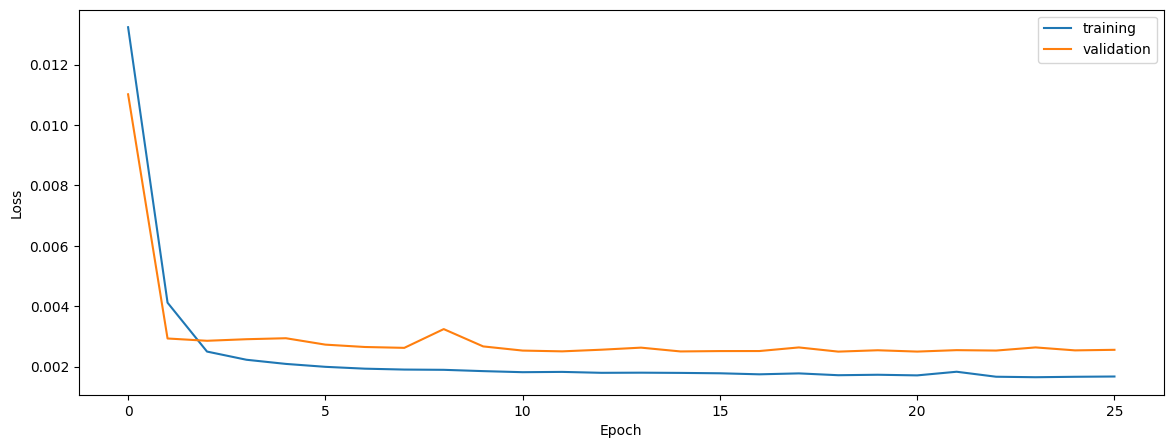

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.927598863164784
0.9101759317528975
0.9359295508496512


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getPearson(train2[1],train_pred2))
print(getPearson(val2[1],val_pred2))
print(getPearson(test2[1],test_pred2))

native
0.927598863164784
0.9101759317528975
0.9359295508496512


In [9]:
print('normalized')
print(getPearson(train2[1][train2[2]],train_pred2[train2[2]]))
print(getPearson(val2[1][val2[2]],val_pred2[val2[2]]))
print(getPearson(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.9304640113095316
0.9111082140795328
0.9453636743857984


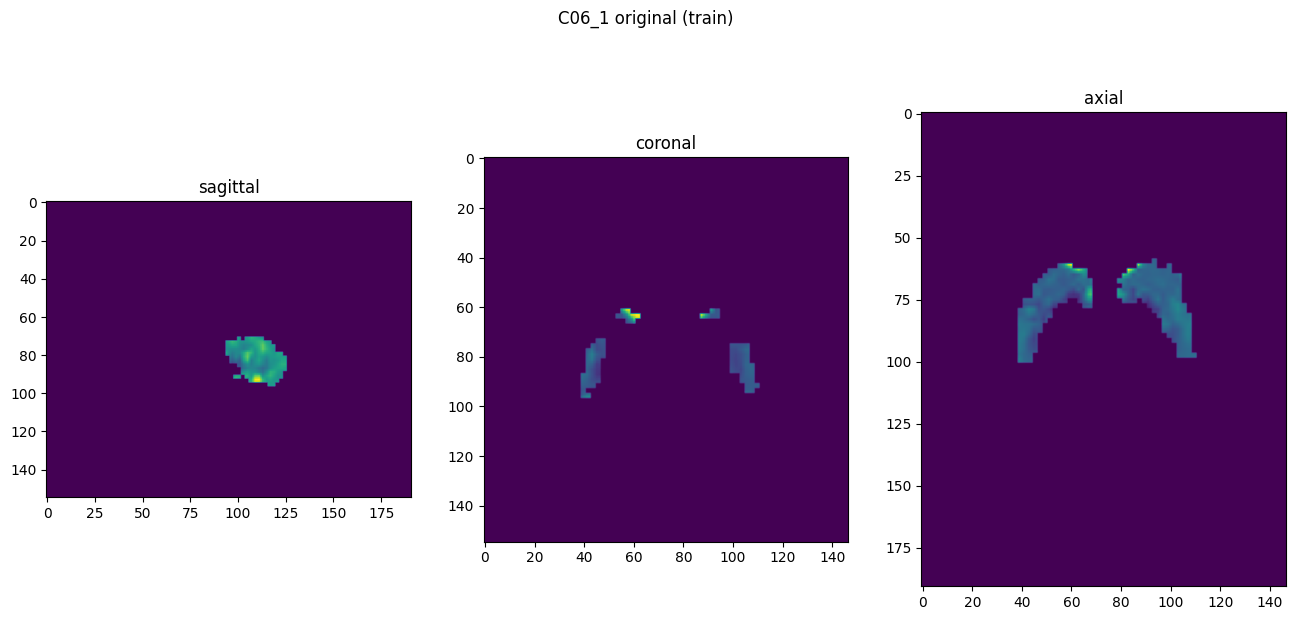

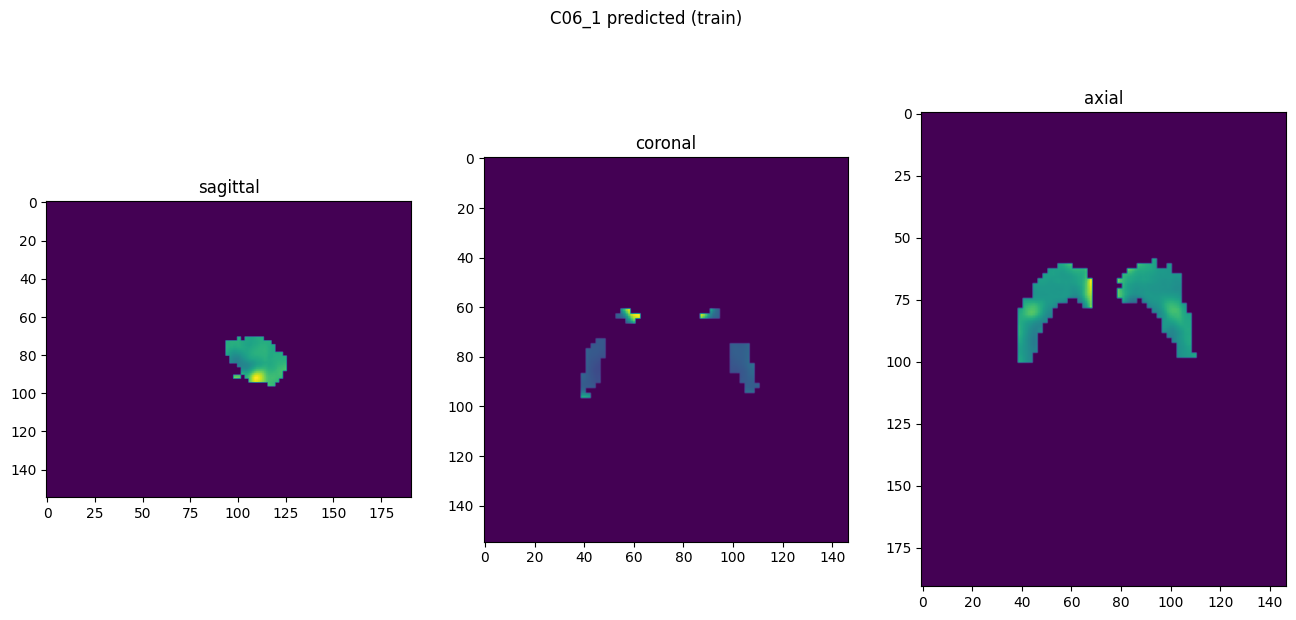

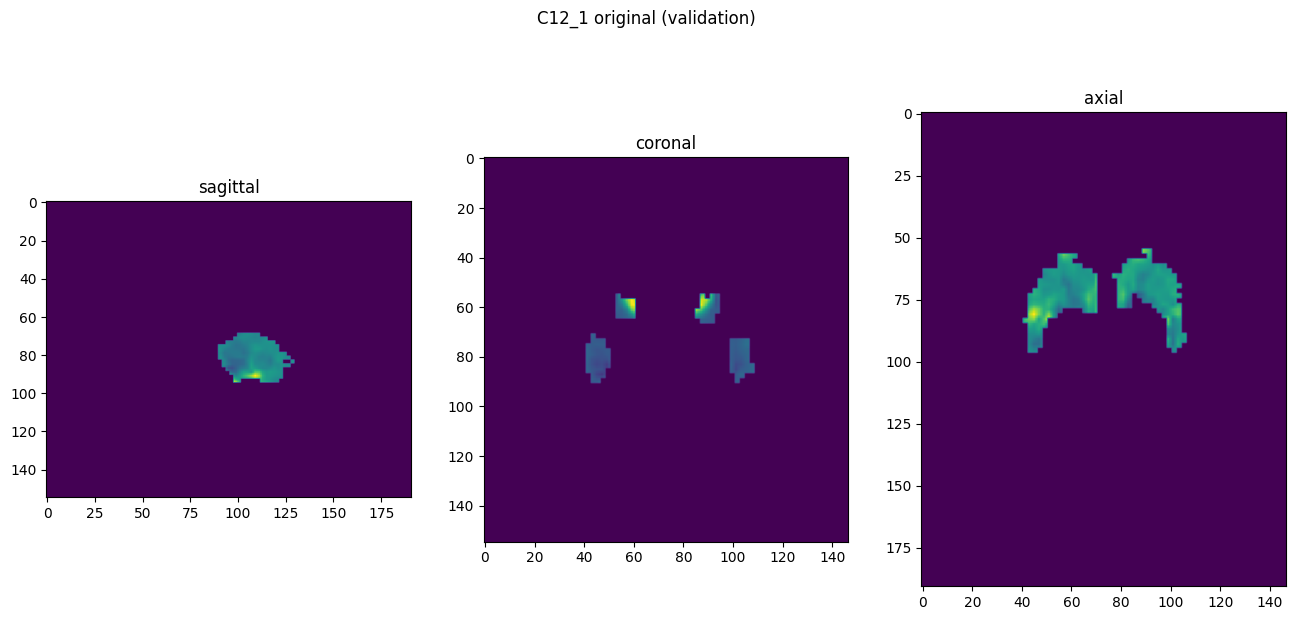

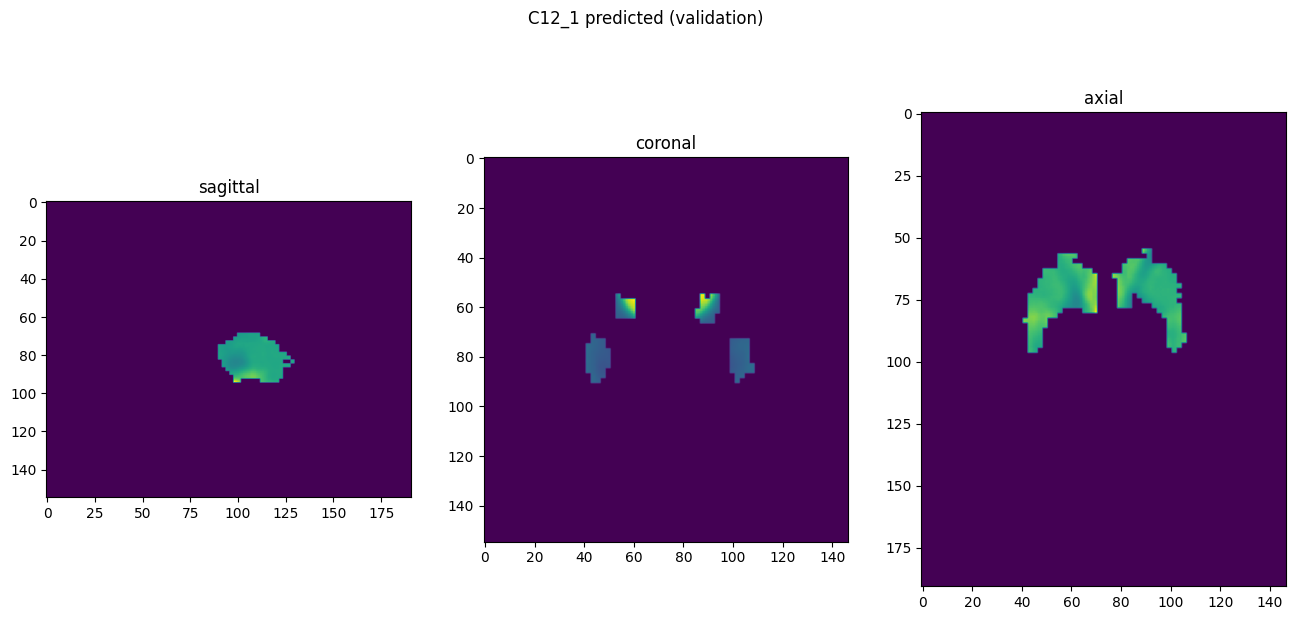

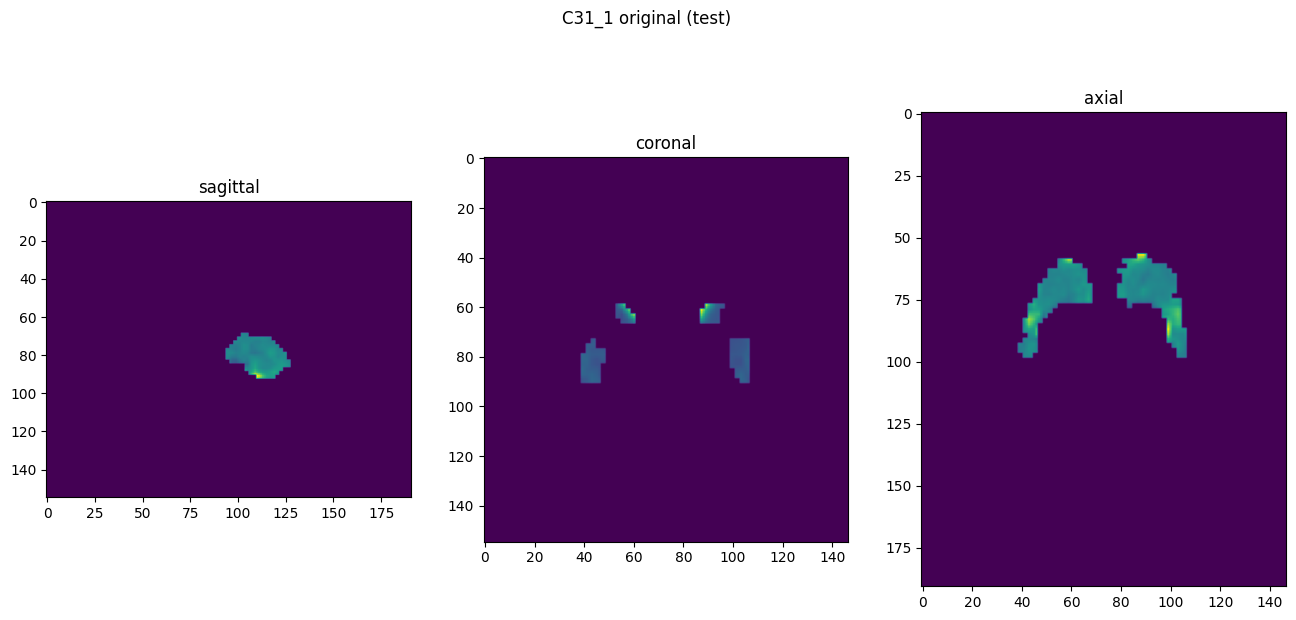

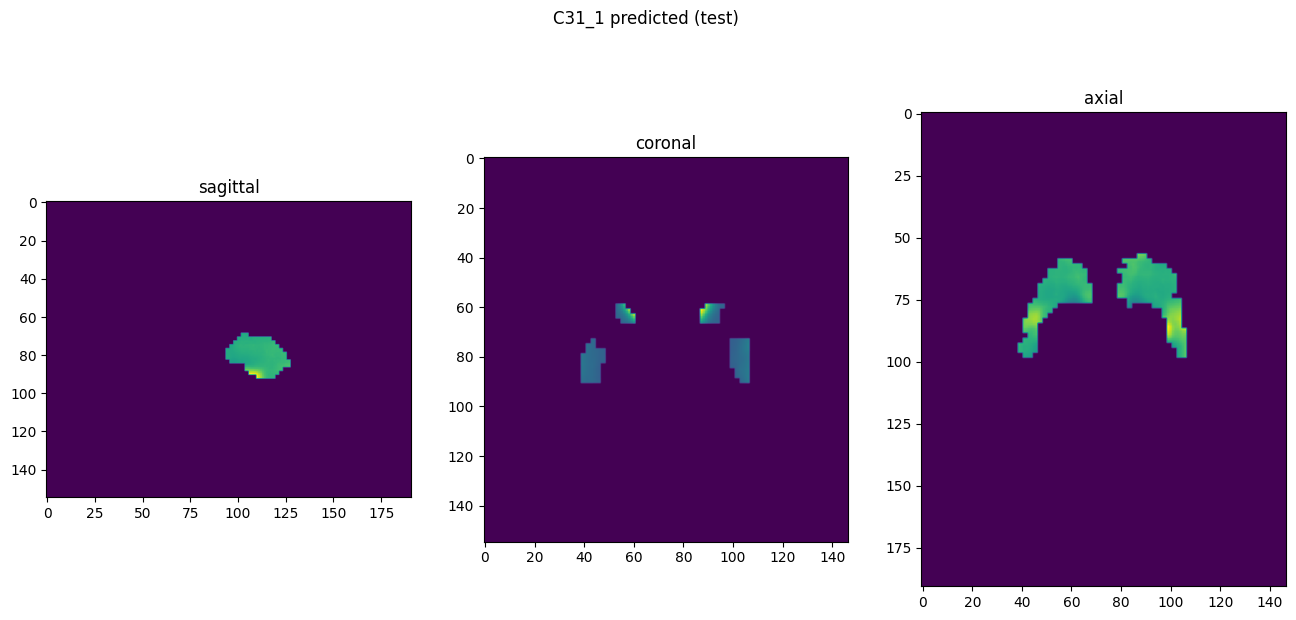

In [10]:
showResults(model, gen, threshold=None, background=False)